<a href="https://colab.research.google.com/github/Lucazere00/music_emotion_recognition/blob/main/music_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installazione delle librerie**

In [1]:
!pip install librosa --upgrade
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

# **Import**

In [2]:
import seaborn as sns
import pandas as pd
from datetime import datetime
import os
import numpy as np
from google.colab import drive
import librosa
import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# **Dataset**

In [3]:
import kagglehub

path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")

print("Path to dataset files:", path)

100%|██████████| 1.83G/1.83G [01:27<00:00, 22.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1


In [4]:
dataset_path = '/root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1'
print(os.listdir(dataset_path))

audio_dir = os.path.join(dataset_path, 'DEAM_audio', 'MEMD_audio')
annotations_dir = os.path.join(dataset_path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'song_level',
                          'static_annotations_averaged_songs_1_2000.csv')

# verifico i paths
print("Audio Directory Path:", audio_dir)
print("Static CSV Path:", annotations_dir)

# verifico se i paths esistono
if os.path.exists(audio_dir):
    print("Audio directory exists.")
else:
    print("Audio directory does not exist!")

if os.path.exists(annotations_dir):
    print("Static CSV file exists.")
else:
    print("Static CSV file does not exist!")

['features', 'DEAM_Annotations', 'DEAM_audio']
Audio Directory Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_audio/MEMD_audio
Static CSV Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv
Audio directory exists.
Static CSV file exists.


# **Breve EDA (Exploratory data analysis)**

In [5]:

# genero il dataframe pandas
annotations_df = pd.read_csv(annotations_dir)

# le prime istanze
print("Dataset Preview:")
print(annotations_df.head())

# informazioni
print("\nDataset Info:")
print(annotations_df.info())

# statistiche
print("\nSummary Statistics:")
print(annotations_df.describe())

Dataset Preview:
   song_id   valence_mean   valence_std   arousal_mean   arousal_std
0        2            3.1          0.94            3.0          0.63
1        3            3.5          1.75            3.3          1.62
2        4            5.7          1.42            5.5          1.63
3        5            4.4          2.01            5.3          1.85
4        7            5.8          1.47            6.4          1.69

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.3 KB
None

Summary Statistics:
           song_id   valence_mean   valence_std   arousal_mean 

In [6]:
# verifico se ci sono valori nulli
print(annotations_df.isna().sum())

song_id          0
 valence_mean    0
 valence_std     0
 arousal_mean    0
 arousal_std     0
dtype: int64


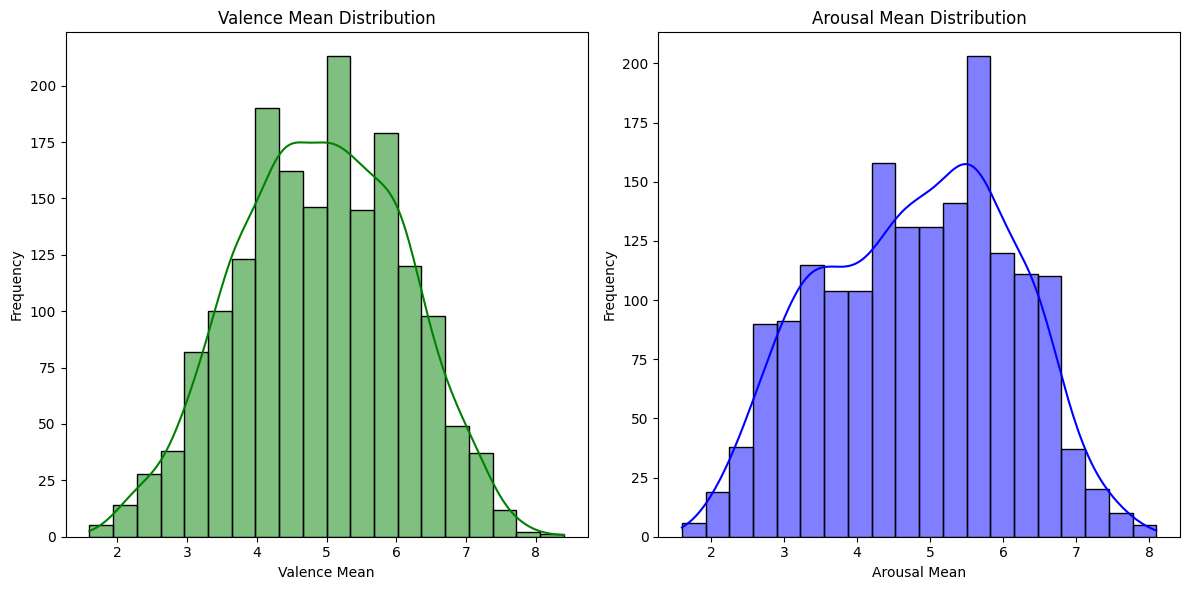

In [7]:
plt.figure(figsize=(12, 6))

annotations_df.columns = annotations_df.columns.str.strip()

# distribuzione valence_mean
plt.subplot(1, 2, 1)
sns.histplot(annotations_df['valence_mean'], kde=True, color='green', bins=20)
plt.title('Valence Mean Distribution')
plt.xlabel('Valence Mean')
plt.ylabel('Frequency')

# # distribuzione arousal_mean
plt.subplot(1, 2, 2)
sns.histplot(annotations_df['arousal_mean'], kde=True, color='blue', bins=20)
plt.title('Arousal Mean Distribution')
plt.xlabel('Arousal Mean')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# **Costruisco le classi emozionali**

In [21]:
def classes(row):
    v = row['valence_mean']
    a = row['arousal_mean']

    # soglia centrale fissa
    threshold = 5.0

    if v >= threshold and a >= threshold:
        return 'Happy'
    elif v < threshold and a >= threshold:
        return 'Angry'
    elif v < threshold and a < threshold:
        return 'Sad'
    else:
        return 'Relaxed'

# aggiungo la colonna label al dataframe
annotations_df['label'] = annotations_df.apply(classes, axis=1)

# verifico la distribuzione delle classi
print(annotations_df['label'].value_counts())
print(annotations_df[['song_id', 'valence_mean', 'arousal_mean', 'label']].head(10))

label
Sad        671
Happy      634
Relaxed    222
Angry      217
Name: count, dtype: int64
   song_id  valence_mean  arousal_mean  label
0        2           3.1           3.0    Sad
1        3           3.5           3.3    Sad
2        4           5.7           5.5  Happy
3        5           4.4           5.3  Angry
4        7           5.8           6.4  Happy
5        8           3.2           4.8    Sad
6       10           4.0           4.7    Sad
7       12           5.5           5.8  Happy
8       13           3.2           4.0    Sad
9       17           4.4           6.0  Angry


# **Estrazione del Mel-Spectrogram**

In [22]:
def extract_mel_segment(file_path, start_sec, duration=5, n_mels=128, max_len=256):
    # Carichiamo solo il segmento che ci interessa (offset e duration)
    y, sr = librosa.load(file_path, sr=22050, offset=start_sec, duration=duration)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalizzazione tra 0 e 1 (aiuta molto la CNN a convergere)
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

    # Padding/Cropping per assicurare che la larghezza sia max_len
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db

In [28]:
from tqdm import tqdm
X = []
y = []

for index, row in tqdm(annotations_df.iterrows(), total=annotations_df.shape[0], desc="Estrazione Spettrogrammi"):
    file_path = os.path.join(audio_dir, f"{int(row['song_id'])}.mp3")
    label = row['label']

    if not os.path.exists(file_path): continue

    # Decidiamo quanti segmenti estrarre per bilanciare
    # Se Happy/Sad (tanti brani) -> 2 segmenti da 15s
    # Se Angry/Relaxed (pochi brani) -> 6 segmenti da 5s
    if label in ['Happy', 'Sad']:
        segments = [(0, 15), (20, 15)] # (inizio, durata)
    else:
        segments = [(i*7, 5) for i in range(6)] # 6 pezzi da 5 secondi

    for start, dur in segments:
        try:
            # Specifichiamo una max_len comune (es 256) per avere spettrogrammi uguali
            mel_spec = extract_mel_segment(file_path, start_sec=start, duration=dur, max_len=256)
            X.append(mel_spec)
            y.append(label)
        except Exception as e:
            continue


Estrazione Spettrogrammi: 100%|██████████| 1744/1744 [04:46<00:00,  6.10it/s]


# **Preprocessing e codifica**

In [29]:
X = np.array(X)[..., np.newaxis]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print("Classi mappate:", label_encoder.classes_)
print("Forma X:", X.shape) # Dovrebbe essere (N_Campioni, 128, 256, 1)

Classi mappate: ['Angry' 'Happy' 'Relaxed' 'Sad']
Forma X: (5244, 128, 256, 1)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42)

In [46]:
import pickle
from google.colab import files # Solo se sei su Colab

# Salva l'encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Scaricalo
files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Definizione della rete neurale CNN**

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Cambiato input_shape a 256 di larghezza
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 256, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Aggiungiamo un terzo blocco per gestire la complessità dell'audio
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Aumentato leggermente per gestire il rumore delle label
    Dense(4, activation='softmax') # Assicurati che CLASSES siano 4
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 125, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 53760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,881,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,975,492 (26.61 MB)

 Trainable params: 6,975,044 (26.61 MB)

 Non-trainable params: 448 (1.75 KB)

# **Addestramento del modello**

In [41]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.5510 - loss: 5.5303 - val_accuracy: 0.2564 - val_loss: 15.1705
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6174 - loss: 0.7603 - val_accuracy: 0.2564 - val_loss: 36.2787
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6419 - loss: 0.7704 - val_accuracy: 0.3136 - val_loss: 17.1970
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6474 - loss: 0.6077 - val_accuracy: 0.5396 - val_loss: 1.2733
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6453 - loss: 0.6789 - val_accuracy: 0.5100 - val_loss: 2.2339
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6513 - loss: 0.5931 - val_accuracy: 0.6778 - val_loss: 0.5419
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6358 - loss: 0.6125 - val_accuracy: 0.6759 - val_loss: 0.5166
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6500 - loss: 0.6373 - va

# **Valutazione**

In [42]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy sul test set: {accuracy:.2f}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6654 - loss: 0.7397
Accuracy sul test set: 0.66


In [43]:
model.save('music_emotion_recognition_model.h5')

# **Visualizzazione andamento**

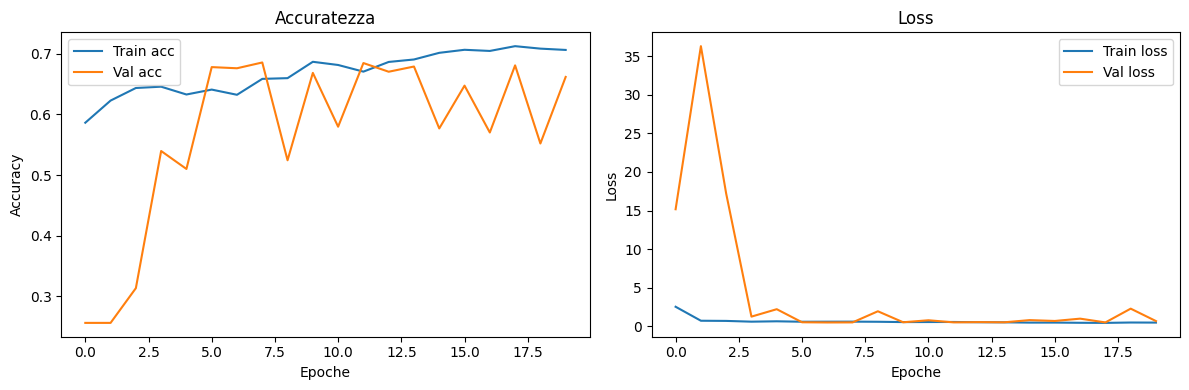

In [45]:
plt.figure(figsize=(12, 4))

#con plt.plot(...) mostriamo accuracy e loss nel tempo

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuratezza')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()

# Salvo la figura in Drive
plt.tight_layout()
plt.show()